In [1]:
# Add root directory to path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.abspath('..'),
                  os.pardir)
)
numericalExperimentsPath = os.path.abspath('..')

sys.path.append(PROJECT_ROOT)

# Imports
from electronTransportCode.SimOptions import LineSource
from electronTransportCode.SimulationDomain import SimulationDomain
from electronTransportCode.MCParticleTracer import AnalogParticleTracer
from electronTransportCode.MCEstimator import FluenceEstimator, DoseEstimator, TrackEndEstimator
from electronTransportCode.ParticleModel import PointSourceParticle
from electronTransportCode.Material import unitDensityMaterial
%matplotlib widget

### Set up all objects
Either do simulation, or load objects from data file

In [2]:
SEED: int = 4  # Random number generator seed
SIM: bool = True

if SIM:
    NB_PARTICLES = 30000
    
    # Set up initial conditions
    eSource: float = 1.0

    # Set up simulation domain
    xmin = -1.3; xmax = 1.3; xbins = 100
    ymin = -1.3; ymax = 1.3; ybins = 100
    simDomain = SimulationDomain(xmin, xmax, ymin, ymax, xbins, ybins, material=unitDensityMaterial)
    pointSourceSim = LineSource(minEnergy=0.0, rngSeed=SEED, eSource=eSource, xmin=-1.3, xmax=1.3)

    # Set up dose estimator
    Ebins = 100
    fluenceEstimator = FluenceEstimator(simDomain=simDomain, Emin=0.0, Emax=eSource, Ebins=Ebins)
    doseEstimator = DoseEstimator(simDomain)
    trackEndEstimatorrz = TrackEndEstimator(simDomain, NB_PARTICLES, setting='rz-Linesource')

    # Set up particle
    particle = PointSourceParticle(generator=SEED)  # rng is later overridden by simulation object 

    # Set up particle tracer
    particleTracer = AnalogParticleTracer(particle=particle, simOptions=pointSourceSim, simDomain=simDomain)
    
    particleTracer(nbParticles=NB_PARTICLES, estimators=(fluenceEstimator, doseEstimator, trackEndEstimatorrz))
    trackEndEstimatorrz.scoreMatrix = trackEndEstimatorrz.scoreMatrix[:trackEndEstimatorrz.index]
    print(f'Average amount of events: {particleTracer.averageNbCollisions}')
else:
    raise NotImplementedError
    with open('data/particleTracer.pkl', 'rb') as file:
        particleTracer = pickle.load(file)
        
    with open('data/fluenceEstimator.pkl', 'rb') as file:
        fluenceEstimator = pickle.load(file)
        
    with open('data/doseEstimator.pkl', 'rb') as file:
        doseEstimator = pickle.load(file)
        
    with open('data/trackEndEstimator.pkl', 'rb') as file:
        trackEndEstimator = pickle.load(file)

    particle = particleTracer.particle
    simDomain = particleTracer.simDomain
    pointSourceSim = particleTracer.simOptions

    eSource= pointSourceSim.eSource
    xmin = simDomain.xmin
    xmax = simDomain.xmax
    ymin = simDomain.ymin
    ymax = simDomain.ymax
    xbins = simDomain.xbins
    ybins = simDomain.ybins
    Ebins = fluenceEstimator.Ebins

Last 1000 particles took 4.065945185997407 seconds. 3.3333333333333335% completed.
Last 1000 particles took 3.6103984149995085 seconds. 6.666666666666667% completed.
Last 1000 particles took 3.0867408370031626 seconds. 10.0% completed.


KeyboardInterrupt: 

In [ ]:
# Sanity check
print(doseEstimator.scoreMatrix.sum())  # Total energy and total simulation time. Should be equal to the amount of particles.

30000.0


Plot 2D particle distribution

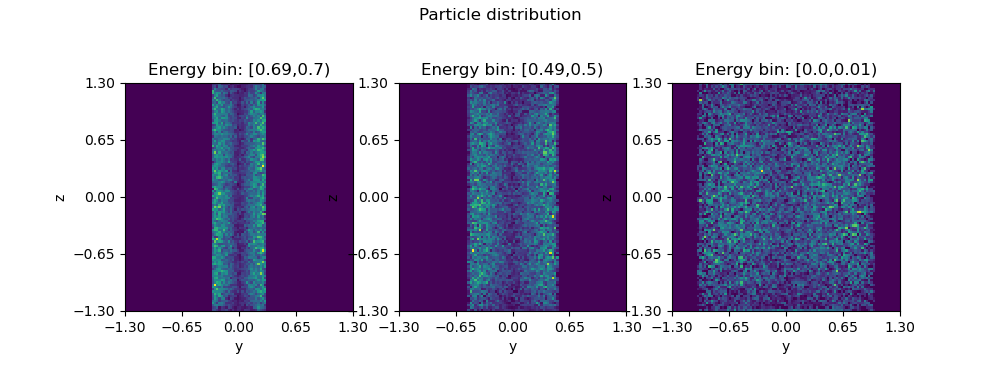

In [ ]:
# Plot energy deposition
ebin2Index = 0
ebin1Index = int((Ebins-1)/2)
ebin3Index = int(7*(Ebins-1)/10)
Fluence3 = np.flipud(np.reshape(fluenceEstimator.scoreMatrix[ebin3Index, :], (ybins, xbins)))
Fluence2 = np.flipud(np.reshape(fluenceEstimator.scoreMatrix[ebin2Index, :], (ybins, xbins)))
Fluence1 = np.flipud(np.reshape(fluenceEstimator.scoreMatrix[ebin1Index, :], (ybins, xbins)))

fig, (ax3, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3.9))
fig.suptitle('Particle distribution')

roundDigits = 3

bin1left = np.round(fluenceEstimator.Erange[ebin1Index], roundDigits)
bin1right = np.round(fluenceEstimator.Erange[ebin1Index+1], roundDigits)
ax1.set_title(f'Energy bin: [{bin1left},{bin1right})')
ax1.matshow(Fluence1, extent=[xmin, xmax, ymin, ymax])
ax1.set_xticks(np.linspace(xmin, xmax, 5))
ax1.set_yticks(np.linspace(xmin, xmax, 5))
ax1.xaxis.tick_bottom()
ax1.set_xlabel('y')
ax1.set_ylabel('z')

# End particle distribution
bin2left = np.round(fluenceEstimator.Erange[ebin2Index], roundDigits)
bin2right = np.round(fluenceEstimator.Erange[ebin2Index+1], roundDigits)
ax2.matshow(Fluence2, extent=[xmin, xmax, ymin, ymax])
ax2.set_title(f'Energy bin: [{bin2left},{bin2right})')
ax2.set_xticks(np.linspace(xmin, xmax, 5))
ax2.set_yticks(np.linspace(xmin, xmax, 5))
ax2.xaxis.tick_bottom()
ax2.set_xlabel('y')
ax2.set_ylabel('z')

bin3left = np.round(fluenceEstimator.Erange[ebin3Index], roundDigits)
bin3right = np.round(fluenceEstimator.Erange[ebin3Index+1], roundDigits)
ax3.set_title(f'Energy bin: [{bin3left},{bin3right})')
ax3.matshow(Fluence3, extent=[xmin, xmax, ymin, ymax])
ax3.set_xticks(np.linspace(xmin, xmax, 5))
ax3.set_yticks(np.linspace(xmin, xmax, 5))
ax3.xaxis.tick_bottom()
ax3.set_xlabel('y')
ax3.set_ylabel('z')


plt.show()

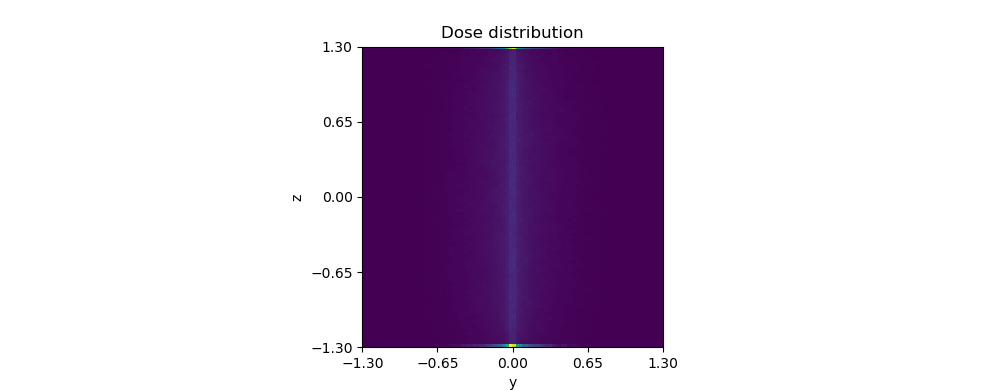

In [ ]:
# Dose distribution. Simulate a low number of tracks to see the paths.
dose = np.flipud(np.reshape(doseEstimator.scoreMatrix, (ybins, xbins)))

fig, ax1 = plt.subplots(figsize=(10, 3.9))
ax1.matshow(dose, extent=[xmin, xmax, ymin, ymax])
ax1.set_title(f'Dose distribution')
ax1.set_xticks(np.linspace(xmin, xmax, 5))
ax1.set_yticks(np.linspace(xmin, xmax, 5))
ax1.xaxis.tick_bottom()
ax1.set_xlabel('y')
ax1.set_ylabel('z')

plt.show()

In [ ]:
# # Compute exact solution at E = 0 (t = 1)
# from numericalExperiments.pointSource import exactSolution

# solRes = 501
# rsTemp = np.linspace(0.0, 1.0, solRes)  # Discontuity from the source at the origin
# rs = np.zeros((solRes-1, ))

# for index in range(solRes-1):
#     rs[index] = (rsTemp[index]+rsTemp[index+1])/2

# resr = np.zeros_like(rs)
# for index, r in enumerate(rs):
#     resr[index] = exactSolution.pointSourceSolution(r, 0.0, eSource)

# # Normalize
# resr = resr/np.trapz(resr, rs)  

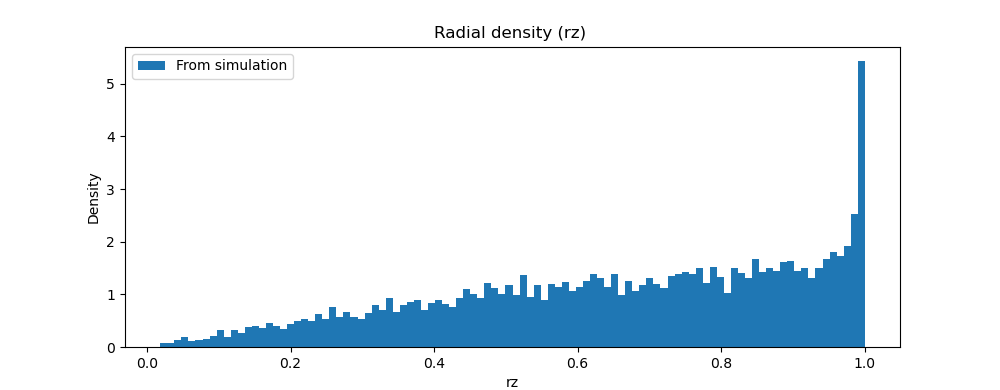

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 3.9))
rxdensity = trackEndEstimatorrz.scoreMatrix
binVal, binEdge, _ = ax1.hist(rxdensity, bins=100, density=True, label='From simulation')
ax1.set_xlabel('rz')
ax1.set_ylabel('Density')
ax1.set_title('Radial density (rz) ')
# ax1.plot(rs, resr, label='Exact radial density')
ax1.legend()